In [1]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras
import torch

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os

import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
import tensorflow

Using TensorFlow backend.


In [2]:
path = './data/Train/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

Text(0.5, 1.0, 'Negative and Positive')

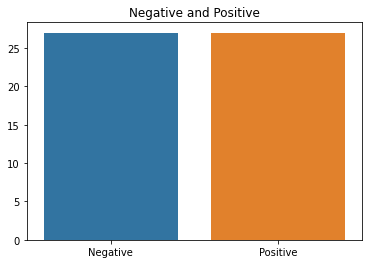

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,./data/Train\Negative\16070.jpg,Negative
1,./data/Train\Negative\00930.jpg,Negative
2,./data/Train\Negative\18970.jpg,Negative
3,./data/Train\Positive\18642_1.jpg,Positive
4,./data/Train\Negative\10579.jpg,Negative


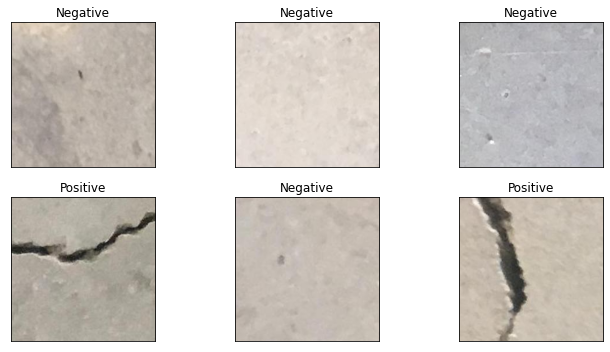

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.1)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=16,
        shuffle=True
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        class_mode='categorical',
        batch_size=16,
        shuffle=False
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    outputs = Dense(2, activation='softmax')(pre_model.output)

    model = Model(inputs=inputs, outputs=outputs)
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss = 'categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              mode='auto')]
    return model, my_callbacks

In [9]:
def plot(history,df_test,test_gen,train_gen, model):

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [11]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [12]:
MobileNet_model, callback=func(MobileNet)

In [13]:
MobileNet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [14]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=10,
    callbacks=callback
)

Epoch 1/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0629 - accuracy: 0.9836 - val_loss: 0.0128 - val_accuracy: 0.9970
Epoch 2/10
2000/2000 [==============================] - 87s 43ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0073 - val_accuracy: 0.9980
Epoch 3/10
2000/2000 [==============================] - 87s 43ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0057 - val_accuracy: 0.9984
Epoch 4/10
2000/2000 [==============================] - 89s 45ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 0.9989
Epoch 5/10
2000/2000 [==============================] - 90s 45ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0039 - val_accuracy: 0.9990
Epoch 6/10
2000/2000 [==============================] - 91s 46ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 7/10
2000/2000 [==============================] - 92s 46ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0031 -

In [15]:
MobileNet_model.save('./saved/Crack_Detection_MobileNet_model.h5')

In [16]:
hist_df = pd.DataFrame(history_MobileNet.history) 

# or save to csv: 
hist_csv_file = './saved/history_MobileNet_model.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index = False)
    
history = pd.read_csv("./saved/history_MobileNet_model.csv")
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.062929,0.983563,0.012796,0.997031
1,0.009562,0.997656,0.007344,0.998000
2,0.006602,0.998281,0.005696,0.998406
3,0.005217,0.998594,0.004565,0.998875
4,0.004473,0.998781,0.003885,0.998969


              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      4036
    POSITIVE       1.00      1.00      1.00      3964

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



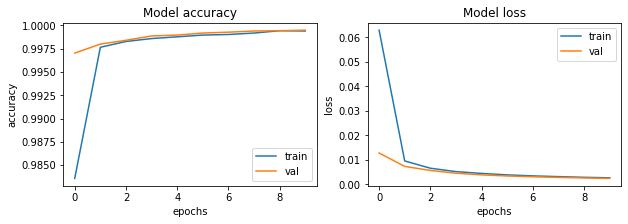

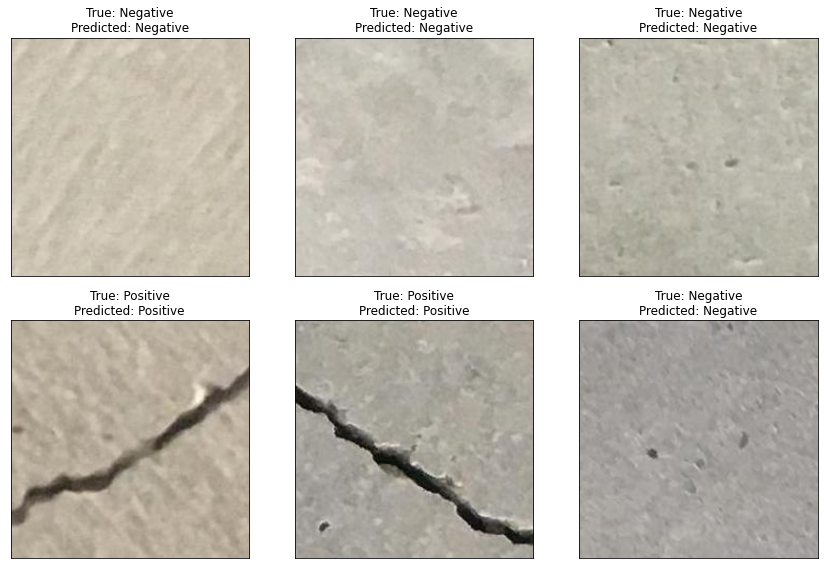

In [17]:
history=plot(history_MobileNet,test_df,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

In [18]:
result_MobileNet = result_test(test_gen_MobileNet, MobileNet_model)

    Test Loss: 0.00422
Test Accuracy: 99.87%


In [19]:
output = pd.DataFrame({'Model':['MobileNet'],
                      'Accuracy':[result_MobileNet[1]]})

In [20]:
output

,Model,Accuracy
0,MobileNet,0.99875


# To test the accuracy on the augmented test data

In [21]:
import torch

In [22]:
test_images, labels = torch.load('./data/Test/small_1000_set.pth')

In [23]:
MobileNet_model = tensorflow.keras.models.load_model('./saved/Crack_Detection_MobileNet_model.h5')

In [24]:
test_images = test_images.numpy()

In [25]:
test_images.shape

(1000, 3, 227, 227)

In [26]:
images = []
for test_img in test_images:
    images.append(np.moveaxis(test_img, 0, -1))
    
images = np.array(images)

In [27]:
images.shape

(1000, 227, 227, 3)

In [28]:
from PIL import Image 

for i in range(1000):
    path = './data/Test/'
    if labels[i] == 0:
        path += 'Negative/'
    else:
        path += 'Positive/'
    
    img_arr = np.squeeze(images[i])
    _array = img_arr * 255
    _array = _array.astype(np.uint8)
    _image = Image.fromarray(_array)
    _image = _image.save(path + str(i) + '.jpg')

In [29]:
path = './data/Test/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

In [30]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

In [31]:
from tensorflow.keras.applications.mobilenet import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=data,
    x_col='File_Path',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 1000 validated image filenames belonging to 2 classes.


In [32]:
result_MobileNet = result_test(test_gen, MobileNet_model)

    Test Loss: 0.11723
Test Accuracy: 97.70%
